<a href="https://colab.research.google.com/github/Jaybhatt216/EIT/blob/main/LSTM_pytorch_dino_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
class Layer(torch.nn.Module):
    #size in is size before size out is out for this layer
    def __init__(self,size_in,size_out,activation):
        super(Layer,self).__init__()
        self.weights = torch.nn.Parameter(torch.randn(size_in,size_out,requires_grad=True))
        self.bias = torch.nn.Parameter(torch.randn(1,size_out,requires_grad=True))
        self.activation = activation


    def Forward(self, z_in):
        return self.activation(z_in @self.weights + self.bias) 

In [3]:
forget = Layer(38,15,torch.nn.Sigmoid())
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(forget.parameters())

In [4]:
x_in=torch.randn(1,38)
y = torch.rand(1,15)

In [5]:
print(forget.bias)
out = forget.Forward(x_in)
loss = loss_func(out,y)
loss.backward()
opt.step()
opt.zero_grad()
print(forget.bias)

Parameter containing:
tensor([[-0.1751,  0.4333, -0.1316,  1.4403, -0.2039, -0.4930,  1.7200,  0.7571,
         -0.3826, -0.1672, -0.4185,  0.1706,  0.6638, -0.5649,  1.4592]],
       requires_grad=True)
Parameter containing:
tensor([[-0.1741,  0.4323, -0.1306,  1.4393, -0.2049, -0.4940,  1.7190,  0.7561,
         -0.3816, -0.1662, -0.4195,  0.1716,  0.6628, -0.5659,  1.4582]],
       requires_grad=True)


In [6]:
class RNN(torch.nn.Module):
    def __init__(self, size_in, size_out, size_mem):
        super(RNN, self).__init__()
        self.size_mem = size_mem
        self.mem_layer = Layer(size_in + size_mem, size_mem, torch.tanh)
        self.out_layer = Layer(size_mem, size_out, torch.sigmoid)
        
    def Forward(self, X):
        
        mem = torch.zeros(1,self.size_mem)
        y_hat=[]
        for i in range(X.shape[0]):
            x_in = X[[i],:]
            z_in = torch.cat([x_in,mem], dim=1)
            mem = self.mem_layer.Forward(z_in)
            y_hat.append(self.out_layer.Forward(mem))
            
        return torch.cat(y_hat, dim=0)

In [7]:
rnn = RNN(38, 15, 5)
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters())

In [8]:
print(rnn.mem_layer.bias)
y_hat = rnn.Forward(x_in)
loss = loss_func(y_hat, y)
loss.backward()
opt.step()
opt.zero_grad()
print()
print(rnn.mem_layer.bias)

Parameter containing:
tensor([[-0.2850,  0.3023, -0.8575,  2.0131, -0.2946]], requires_grad=True)

Parameter containing:
tensor([[-0.2840,  0.3033, -0.8585,  2.0141, -0.2936]], requires_grad=True)


In [9]:
class LSTM(torch.nn.Module):
    def __init__(self, size_in, size_out, size_long, size_short):
        super(LSTM, self).__init__()
        self.size_long = size_long
        self.size_short = size_short
        
        size_z = size_in + size_short
        
        self.forget_gate  = Layer(size_z, size_long, torch.sigmoid)
        self.memory_gate  = Layer(size_z, size_long, torch.sigmoid)
        self.memory_layer = Layer(size_z, size_long, torch.tanh)
        self.recall_gate  = Layer(size_z, size_short, torch.sigmoid)
        self.recall_layer = Layer(size_long, size_short, torch.tanh)
        self.output_gate  = Layer(size_short, size_out, torch.sigmoid)
        
    def Forward(self, X):
        mem_short = torch.zeros(1, self.size_short)
        mem_long = torch.zeros(1, self.size_long)
        y_hat = []
        
        for i in range(X.shape[0]):
            x_t = X[[i],:]
            z_t = torch.cat([x_t,mem_short], dim=1)
            mem_long = mem_long*self.forget_gate.Forward(z_t)
            mem_long = mem_long+(self.memory_gate.Forward(z_t)*self.memory_layer.Forward(z_t))
            mem_short = self.recall_gate.Forward(z_t)+self.recall_layer.Forward(mem_long)
            
            y_hat.append(self.output_gate.Forward(mem_short))
            
        return torch.cat(y_hat, dim=0)
    
    def Generate(self, start, stop, random_factor):
        y_hat = [start]
        mem_long = torch.randn([1,self.size_long])*random_factor
        mem_short = torch.randn([1, self.size_short])*random_factor
        
        while(y_hat[-1] != stop).any() and len(y_hat)<30:
            x_t = y_hat[-1]
            z_t = torch.cat([x_t, mem_short], dim=1)
            mem_long = mem_long*self.forget_gate.Forward(z_t)
            mem_long = mem_long + (self.memory_gate.Forward(z_t)*self.memory_layer.Forward(z_t))
            mem_short = self.recall_gate.Forward(z_t) + self.recall_layer.Forward(mem_long)
            out = self.output_gate.Forward(mem_short)
            out = torch.argmax(out,dim=1)
            
            y_hat.append(torch.zeros(stop.shape))
            y_hat[-1][0,out]=1
            
        return torch.cat(y_hat, dim=0)

In [11]:
data = pd.read_csv('dinosaurs.csv', header=None)

In [12]:
data.columns=['name']

In [13]:
def Process(name):
    name=''.join(['{',name,'|'])
    out=[]
    for letter in name:
        row=torch.zeros([1,28])
        row[0,ord(letter)-97]=1
        out.append(row)
    return torch.cat(out)

def Decode(y_hat):
    out=''
    for i in torch.argmax(y_hat,dim=1):
        out += chr(i+97)
    return out

In [14]:
lstm = LSTM(28,28,12,12)

In [15]:
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(lstm.parameters(), lr=4.5e-2)

r\ Iteration: 0 Loss: -0.7636379599571228 | {l|hl{zzz{zzz 
r\ Iteration: 1 Loss: 2.2463362216949463 | {ls{zsz{z{{{{{ 
r\ Iteration: 2 Loss: 2.1493022441864014 | {ls{llllllllllllll 
r\ Iteration: 3 Loss: 2.552077293395996 | {lzleeslllllll 
r\ Iteration: 4 Loss: 2.5400233268737793 | {lsllllxxil||ellxl 
r\ Iteration: 5 Loss: 2.5765037536621094 | {l{leel 
r\ Iteration: 6 Loss: 2.4012691974639893 | {{|llllllllll 
r\ Iteration: 7 Loss: 2.4050838947296143 | {{|elll|llll| 
r\ Iteration: 8 Loss: 2.54931640625 | {{allll|lllxxeli 
r\ Iteration: 9 Loss: 2.546480655670166 | {{|llll|ll|raa 
r\ Iteration: 10 Loss: 2.2507517337799072 | r{a|ll||ll|rsasra 
r\ Iteration: 11 Loss: 2.3109920024871826 | rl|l|l|llsssraa 
r\ Iteration: 12 Loss: 2.302211284637451 | r{aasa||||ll|| 
r\ Iteration: 13 Loss: 2.1436259746551514 | r{a||lll||aa 
r\ Iteration: 14 Loss: 2.2620351314544678 | r{|||l||llaraa 
r\ Iteration: 15 Loss: 2.260436534881592 | rraara||l|ll 
r\ Iteration: 16 Loss: 2.1513044834136963 | rarrrrrrrrrrr 

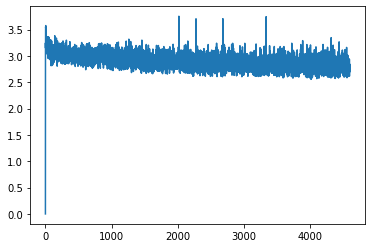

In [16]:
iterations = 4600
losses=[0]
name = '{'

for i in range(iterations):
    
    name = Process(np.random.choice(data.name))
    y_hat = lstm.Forward(name)
    
    print('r\ Iteration: {} Loss: {} | {}'.format(i, loss-1,Decode(y_hat))+' ')
    
    loss = loss_func(y_hat[:-1],torch.argmax(name,dim=1)[1:])
    loss.backward()
    losses.append(loss.detach())
    opt.step()
    opt.zero_grad()
    
plt.plot(losses)

In [21]:
for i in range(100):
  print(Decode(lstm.Generate(Process('{')[[1]],Process('')[[1]],1     )))

{oraasaus|
{oranasaus|
{araasaus|
{harapsaus|
{anananasaus|
{aranasaus|
{ranasaus|
{arasaus|
{harapsaus|
{arapsaus|
{aranasaus|
{harasaus|
{darapsaus|
{saurus|
{darapsaus|
{sarasaus|
{haaasaus|
{ranasaus|
{haranasaus|
{aasaus|
{harapsaus|
{hararapsaus|
{araasaus|
{aranasaus|
{harapsaus|
{darasaus|
{daranasaus|
{horasaus|
{haranasaus|
{aaasaus|
{hananasaus|
{arapsaus|
{asaus|
{harapsaus|
{tarasaus|
{aranasaus|
{rurorapsaus|
{darasaus|
{harapsaus|
{aranasaus|
{harapsaus|
{arapsaus|
{darapsaus|
{hararapsaus|
{orapsaus|
{eraasaus|
{saranasaus|
{araasaus|
{urorapsaus|
{rurururus|
{daranasaus|
{anapsaus|
{araasaus|
{ararapsaus|
{larapsaus|
{orapsaus|
{anapasaus|
{eraasaus|
{haaasaus|
{aasaus|
{harapsaus|
{aaasaus|
{asaurus|
{harapsaus|
{araasaus|
{darasaus|
{darapsaus|
{rananasaus|
{horarapsaus|
{aururus|
{hananasaus|
{aranasaus|
{harasaus|
{harapsaus|
{haasaus|
{ururus|
{harapsaus|
{hararapsaus|
{harasaus|
{harapsaus|
{anasaus|
{aranasaus|
{rorapsaus|
{urasaurus|
{darasaus|
{aaaasaus|
{araa